In [1]:
import pandas as pd
import numpy as np
import os
%load_ext autoreload
%autoreload 2
from src.model.one_class import DeepSVDD
from src.model.reconstruction import DAGMM, MemAutoEncoder
from src.trainer.ids import DeepSVDDIDSTrainer, MemAEIDSTrainer, DAGMMIDSTrainer
from src.utils import metrics
from src.utils.utils import ids_misclf_per_label
from src.datamanager.dataset import IDS2018Dataset
from src.bootstrap import store_results
from pathlib import Path

In [2]:
# Setup base folder structure
dataset_path = "../../data/IDS2018/ids2018.csv"

# General arguments
batch_size = 1024
lr = 1e-4
n_epochs = 200
n_runs = 20
pct = 0.5

models_params = {
    "deepsvdd": {
        "model_cls": DeepSVDD,
        "trainer_cls": DeepSVDDIDSTrainer,
        "compression_factor": 2,
        "n_layers": 4,
        "act_fn": "relu",
        "keep_ckpt": False,
    },
    "dagmm": {
        "model_cls": DAGMM,
        "trainer_cls": DAGMMIDSTrainer,
        "n_mixtures": 4,
        "latent_dim": 1,
        "lambda_1": 0.005,
        "lambda_2": 0.1,
        "reg_covar": 1e-6,
        "compression_factor": 2,
        "act_fn": "relu",
        "n_layers": 4,
        "keep_ckpt": False,
    },
    "memae": {
        "model_cls": MemAutoEncoder,
        "trainer_cls": MemAEIDSTrainer,
        "mem_dim": 50,
        "latent_dim": 1,
        "shrink_thres": 0.0025,
        "n_layers": 4,
        "compression_factor": 2,
        "act_fn": "relu",
        "alpha": 2e-4,
        "keep_ckpt": False,
    }
}

print("arguments set")

arguments set


In [3]:
# Load data
dataset = IDS2018Dataset(path=dataset_path, pct=0.5, seed=42)
# Store label-wise performance
performance_hist = {model_name: {attack_label: [] for attack_label in dataset.labels} for model_name in models_params.keys()}

Training model deepsvdd for 2 runs of 6 epochs each
Initializing center c...
Center c initialized.
Epoch=0	Loss=1.3473
Best epoch=6	Precision=0.6484	Recall=0.6303	Best F1-Score=0.6393


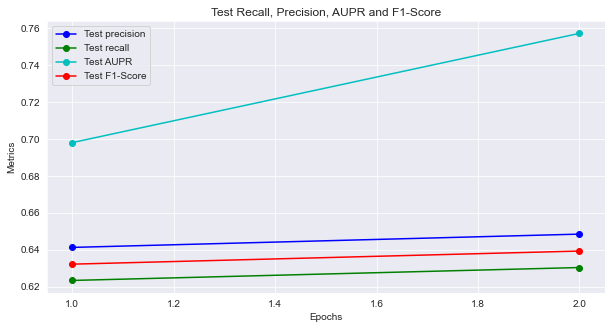

Initializing center c...
Center c initialized.
Epoch=0	Loss=0.6177
Best epoch=6	Precision=0.6974	Recall=0.6779	Best F1-Score=0.6875


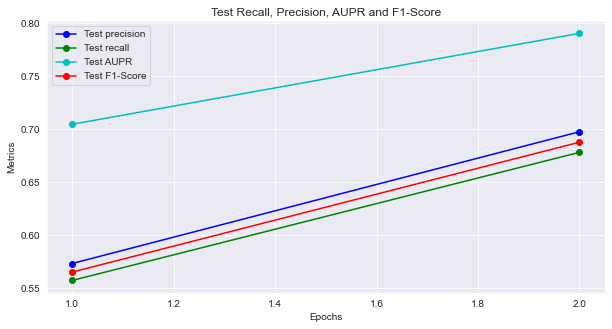

Training model dagmm for 2 runs of 6 epochs each
Epoch=0	Loss=756333.2040
Best epoch=1	Precision=0.6026	Recall=0.5858	Best F1-Score=0.5941


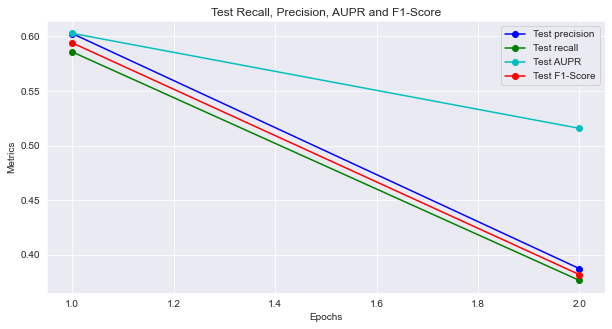

Epoch=0	Loss=1682436.4054
Best epoch=1	Precision=0.6694	Recall=0.6508	Best F1-Score=0.6600


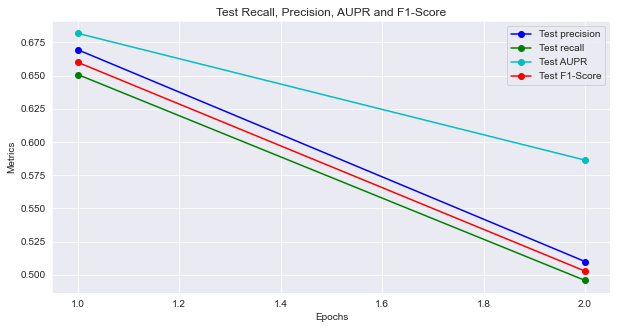

Training model memae for 2 runs of 6 epochs each
Epoch=0	Loss=20.0208
Best epoch=6	Precision=0.6002	Recall=0.5845	Best F1-Score=0.5922


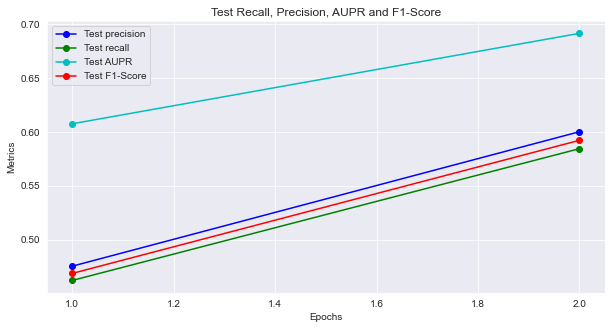

Epoch=0	Loss=22.2514
Best epoch=6	Precision=0.5025	Recall=0.4885	Best F1-Score=0.4954


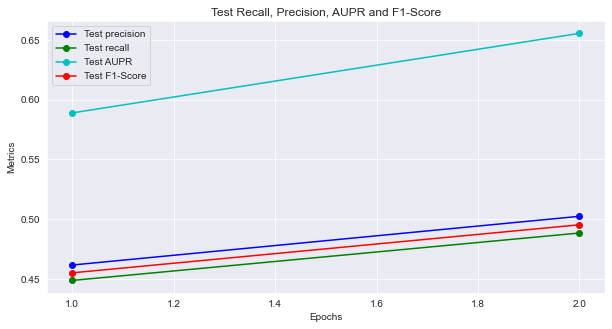

In [5]:
for model_name, params in models_params.items():
    f1_hist = []
    print("Training model {} for {} runs of {} epochs each".format(model_name, n_runs, n_epochs))
    model_cls, trainer_cls = params.pop("model_cls"), params.pop("trainer_cls")
    model_params = dict(
        **params, in_features=dataset.in_features, n_instances=dataset.n_instances, device=device
    )
    for run_i in range(n_runs):
        # Create directories
        ckpt_root = Path(model_name + "/ids2018/train/run_{}".format(run_i + 1))
        ckpt_root.mkdir(parents=True, exist_ok=True)
        ckpt_best_root = Path(model_name + "/ids2018/best")
        ckpt_best_root.mkdir(parents=True, exist_ok=True)
        # Set data loaders
        train_ldr, test_ldr = dataset.loaders(test_pct=0.5, batch_size=batch_size)
        # Set model and trainer
        model = model_cls(**model_params)
        trainer = trainer_cls(
            model=model,
            batch_size=batch_size,
            validation_ldr=test_ldr,
            device=device,
            lr=lr,
            n_epochs=n_epochs,
            run_test_validation=True,
            ckpt_root=str(ckpt_root.absolute()),
            keep_ckpt=True,
        )
        # Train
        trainer.train(train_ldr)
        # Print best F1-Score
        idx = np.argmax(trainer.metric_values["f1-score"])
        precision = trainer.metric_values["precision"][idx]
        recall = trainer.metric_values["recall"][idx]
        f1 = trainer.metric_values["f1-score"][idx]
        best_epoch = idx * 5 + 1
        print("Best epoch={}\tPrecision={:2.4f}\tRecall={:2.4f}\tBest F1-Score={:2.4f}".format(best_epoch, precision, recall, f1))
        # Print figure
        figname = str(ckpt_root.absolute()) + "\\ids2018_thresh-auto.png"
        trainer.plot_metrics(figname=figname)
        # Load best model based on f1-score
        best_ckpt = str(ckpt_root.absolute()) + "\\{}_epoch={}.pt".format(model_name, best_epoch)
        trainer, model = trainer_cls.load_from_file(best_ckpt, trainer, model, device)
        trainer.n_epochs = best_epoch
        best_epoch = 7 * 5 + 1
        # Evaluate best model on binary targets
        y_test_true, test_scores, test_labels = trainer.test(test_ldr)
        results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
        y_pred = (test_scores >= results["Thresh_star"]).astype(int)
        store_results(
            results=results,
            params=dict(batch_size=batch_size, lr=lr, n_epochs=best_epoch, **model.get_params()),
            model_name=model_name,
            dataset="IDS2018",
            dataset_path=dataset_path,
            results_path="./"
        )
        # Save best model
        trainer.save_ckpt(str(ckpt_best_root.absolute()) + "\\best_run_{}_{}.pt".format(run_i + 1, model_name))
        # Evaluate best model on every attack targets
        misclf_df = ids_misclf_per_label(y_pred, y_test_true, test_labels)
        misclf_df = misclf_df.sort_values("Misclassified ratio", ascending=False)
        misclf_df.to_csv(str(ckpt_root.absolute()) + "\\{}_misclassifications.csv".format(model_name))
        for attack_label in dataset.labels:
            performance_hist[model_name][attack_label].append(misclf_df.loc[attack_label, "Misclassified ratio"])

In [ ]:
np.save("./ids2018_performance_hist.npy", performance_hist)